In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

In [2]:
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

In [3]:

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [4]:
images_path = Path('/Users/Rekha/Documents/frcnn/images')
anno_path = Path( '/Users/Rekha/Documents/frcnn/annotations')


def filelist(root, file_type):
    """Let's create a pandas dataframe using the list of dictionaries from the last paragraph"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [5]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,\Users\Rekha\Documents\frcnn\images\road0.png,267,400,trafficlight,98,62,208,232
1,\Users\Rekha\Documents\frcnn\images\road1.png,400,283,trafficlight,154,63,258,281
2,\Users\Rekha\Documents\frcnn\images\road10.png,400,267,trafficlight,106,3,244,263
3,\Users\Rekha\Documents\frcnn\images\road100.png,400,385,speedlimit,35,5,363,326
4,\Users\Rekha\Documents\frcnn\images\road101.png,400,200,speedlimit,195,7,392,194
...,...,...,...,...,...,...,...,...
812,\Users\Rekha\Documents\frcnn\images\road83.png,267,400,stop,181,171,231,218
813,\Users\Rekha\Documents\frcnn\images\road830.png,300,400,speedlimit,81,104,165,185
814,\Users\Rekha\Documents\frcnn\images\road831.png,300,400,speedlimit,69,108,169,204
815,\Users\Rekha\Documents\frcnn\images\road832.png,300,400,speedlimit,74,42,196,161


In [6]:
df_train['class'].value_counts()

speedlimit      612
crosswalk        87
trafficlight     59
stop             59
Name: class, dtype: int64

In [ ]:
# Let's convert our labels to classes:

In [7]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(817, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,\Users\Rekha\Documents\frcnn\images\road0.png,267,400,3,98,62,208,232
1,\Users\Rekha\Documents\frcnn\images\road1.png,400,283,3,154,63,258,281
2,\Users\Rekha\Documents\frcnn\images\road10.png,400,267,3,106,3,244,263
3,\Users\Rekha\Documents\frcnn\images\road100.png,400,385,0,35,5,363,326
4,\Users\Rekha\Documents\frcnn\images\road101.png,400,200,0,195,7,392,194


Resizing images and bounding boxes
Since the images must be the same size to train the computer vision model, we need to resize our images and their corresponding bounding boxes. Resizing the image is easy, but resizing the bounding box is a little more difficult because each rectangle depends on the image and its dimensions.

Here's the basic idea:

We transform the bounding box into an image (mask) of the same size as the image corresponding to this rectangle. This mask will simply have 0 for the background and 1 for the area covering the bounding box.

First, read the image

In [23]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)),cv2.COLOR_BGR2RGB)

#Create a mask for the bounding box with the same shape as the image

def create_mask(bb, x):
    rows,cols,*_ =x.shape
    Y =np.zeros((rows,cols))
    bb = bb.astype(int)
    Y[bb[0]:bb[2] ,bb[1]:bb[3]] =1 
    return Y

 #Convert mask Y into a bounding box, taking 0 as a non-zero background object
    
def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


#Generate the bounding box array from the train_df column

def create_bb_array(x):
    return np.array([x[5],x[4],x[7],x[6]])

#Resize the image and its bounding box and write the image to a new path

def resize_image_bb(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)


In [23]:
#Let's apply all our written functions:

In [13]:
IM_SIZE = 300

In [24]:
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,\Users\Rekha\Documents\frcnn\images\road0.png,267,400,3,98,62,208,232,images_resized\road0.png,"[46.0, 110.0, 173.0, 233.0]"
1,\Users\Rekha\Documents\frcnn\images\road1.png,400,283,3,154,63,258,281,images_resized\road1.png,"[66.0, 115.0, 297.0, 193.0]"
2,\Users\Rekha\Documents\frcnn\images\road10.png,400,267,3,106,3,244,263,images_resized\road10.png,"[3.0, 79.0, 295.0, 182.0]"
3,\Users\Rekha\Documents\frcnn\images\road100.png,400,385,0,35,5,363,326,images_resized\road100.png,"[4.0, 26.0, 253.0, 272.0]"
4,\Users\Rekha\Documents\frcnn\images\road101.png,400,200,0,195,7,392,194,images_resized\road101.png,"[10.0, 146.0, 291.0, 293.0]"


In [21]:
#An example of the resulting sample

(293, 400, 3)


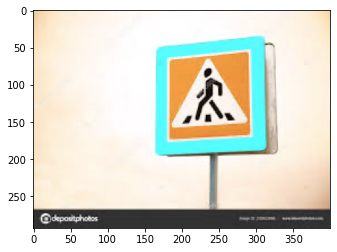

In [26]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)

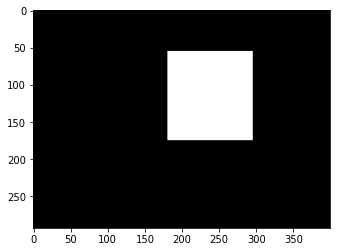

In [31]:
plt.imshow(Y, cmap='gray')

Data Augmentation
Data augmentation is a technique that allows us to better generalize our model by creating new training images using different variations of existing images. There are only 800 images in our current training set, so augmenting the data is very important so that our model does not overfit.
For this task, we will use flip, rotate, center crop and random crop.

The only thing to remember here is to make sure that the bounding box also transforms in the same way as the image. To do this, we follow the same approach as resizing - transform the bounding box to a mask, apply the same transformations to the mask as the original image, and extract the coordinates of the bounding box.

In [33]:
 def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Center cut
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

#Rotate our image

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)


#Returns a random cut"
def random_cropXY(x, Y, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# We transform our picture
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [34]:
#original Image

images_resized\road148.png


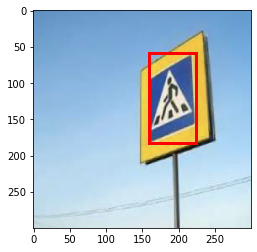

In [39]:
number = 55
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

In [ ]:
#After transformation

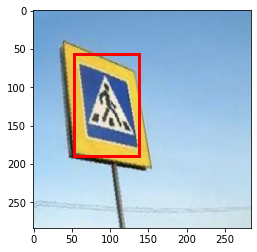

In [40]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

#Dataset                                                                                                                        
Now that we have our data additions, we can create a PyTorch dataset. We will normalize the images using ImageNet statistics because we will be using a pretrained ResNet model and will apply augmentation to the data on our dataset during training.

In [43]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

#Data normalization using ImageNet statistics

def normalize(im):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = RoadDataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)

In [44]:
# load all this into our datalogger:

In [45]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

#Model definition                                                                                                                
We will use a very simple pretrained resNet-34 model as our model. Since we have two tasks here, there are two final layers - Bounding Box Regression and Image Classifier.

In [46]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [47]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:8]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Rekha/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

To calculate the loss, we need to take into account both the loss of classification and the loss of the bounding box regression, so we use a combination of cross entropy and L1 loss (the sum of all absolute differences between the true value and the predicted coordinates.

In [48]:
model = BB_model().cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.006)
epochs = 15
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [49]:
def train():
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [50]:
train()

Epoch [1/15]. train_loss 518.187 val_loss 3409.910 val_acc 0.646
Epoch [2/15]. train_loss 242.003 val_loss 1512.507 val_acc 0.232
Epoch [3/15]. train_loss 144.451 val_loss 189.763 val_acc 0.628
Epoch [4/15]. train_loss 143.731 val_loss 174.969 val_acc 0.604
Epoch [5/15]. train_loss 143.101 val_loss 171.778 val_acc 0.646
Epoch [6/15]. train_loss 145.078 val_loss 163.354 val_acc 0.530
Epoch [7/15]. train_loss 143.253 val_loss 154.317 val_acc 0.652
Epoch [8/15]. train_loss 144.110 val_loss 262.306 val_acc 0.488
Epoch [9/15]. train_loss 141.710 val_loss 147.789 val_acc 0.659
Epoch [10/15]. train_loss 137.044 val_loss 143.707 val_acc 0.604
Epoch [11/15]. train_loss 136.741 val_loss 156.980 val_acc 0.646
Epoch [12/15]. train_loss 130.131 val_loss 145.129 val_acc 0.646
Epoch [13/15]. train_loss 131.568 val_loss 139.455 val_acc 0.622
Epoch [14/15]. train_loss 124.663 val_loss 130.145 val_acc 0.652
Epoch [15/15]. train_loss 119.236 val_loss 119.151 val_acc 0.622


In [51]:
for i, param_group in enumerate(optimizer.param_groups):
    param_group["lr"] = 0.001

In [52]:
train()

Epoch [1/15]. train_loss 112.134 val_loss 112.838 val_acc 0.646
Epoch [2/15]. train_loss 105.746 val_loss 106.497 val_acc 0.634
Epoch [3/15]. train_loss 102.625 val_loss 103.399 val_acc 0.646
Epoch [4/15]. train_loss 102.021 val_loss 100.690 val_acc 0.646
Epoch [5/15]. train_loss 97.713 val_loss 103.069 val_acc 0.640
Epoch [6/15]. train_loss 97.179 val_loss 97.974 val_acc 0.640
Epoch [7/15]. train_loss 93.638 val_loss 91.936 val_acc 0.659
Epoch [8/15]. train_loss 92.058 val_loss 92.138 val_acc 0.659
Epoch [9/15]. train_loss 88.986 val_loss 89.969 val_acc 0.652
Epoch [10/15]. train_loss 88.217 val_loss 87.301 val_acc 0.652
Epoch [11/15]. train_loss 90.801 val_loss 92.821 val_acc 0.646
Epoch [12/15]. train_loss 84.040 val_loss 87.650 val_acc 0.665
Epoch [13/15]. train_loss 83.747 val_loss 88.326 val_acc 0.665
Epoch [14/15]. train_loss 84.464 val_loss 86.357 val_acc 0.659
Epoch [15/15]. train_loss 81.148 val_loss 81.754 val_acc 0.659


In [53]:
# Testing

In [54]:
im = read_image('./images_resized/road789.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [55]:
# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':'./road_signs_test/road789.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 284])

In [56]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 2.7206, -1.8090, -0.7355, -1.5400]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[115.1255, 110.9705, 154.0059, 157.8004]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [57]:
# Predicted Class

In [58]:
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([2.7206], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

In [59]:
class_dict

{'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}

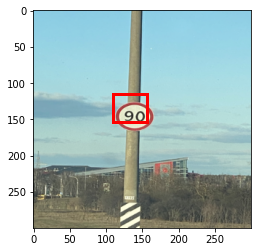

In [60]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])